# **Частина 1. Аналіз та підготовка даних**
### ***(Проаналізуй діапазони значень, їх середні та дисперсію, розподіли, кореляції, наявність пропущених значень, типи ознак)***

In [2]:
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

url = 'https://docs.google.com/spreadsheets/d/1OPnEAT64Patnj_Ifhwn_pM1c15rsBNIoFrtz38A1_W4/edit?usp=sharing'
url = url[:url.find('/edit')] + '/export?format=csv'

df = pd.read_csv(url)
df.head(4)

,ID,Age,Gender,Bedtime,Wakeup time,Sleep duration,Sleep efficiency,REM sleep percentage,Deep sleep percentage,Light sleep percentage,Awakenings,Caffeine consumption,Alcohol consumption,Smoking status,Exercise frequency
0,1,65,Female,2021-03-06 01:00:00,2021-03-06 07:00:00,6.0,0.88,18,70,12,0.0,0.0,0.0,Yes,3.0
1,2,69,Male,2021-12-05 02:00:00,2021-12-05 09:00:00,7.0,0.66,19,28,53,3.0,0.0,3.0,Yes,3.0
2,3,40,Female,2021-05-25 21:30:00,2021-05-25 05:30:00,8.0,0.89,20,70,10,1.0,0.0,0.0,No,3.0
3,4,40,Female,2021-11-03 02:30:00,2021-11-03 08:30:00,6.0,0.51,23,25,52,3.0,50.0,5.0,Yes,1.0


In [3]:
#Заміщаемо колонку Bedtime колокою bedtime norm що приводть старт відходу до сну від 21:00
df['Bedtime'] = pd.to_datetime(df['Bedtime'])
df['Bedtime'] = df['Bedtime'].apply(lambda x: x.hour + (0.5 if x.time().minute > 0 else 0))
df['Bedtime'] = df['Bedtime'].apply(lambda x: (x + 24 - 21)%24)
df.rename(columns={'Bedtime': 'bedtime norm'}, inplace=True)

# Пусті значення заміщуємо на "0"
df.fillna(0, inplace=True)

# Smoking status приводимо до bool
df['Smoking status'] = df['Smoking status'].replace({'Yes': True, 'No': False})
df['Smoking status'] = df['Smoking status'].astype(bool)

# Прибираємо зайві колонки
df = df.drop(
    columns=[
        'ID',
        'Gender',
        'Wakeup time'
    ]
)

In [4]:
# піготовлені дані для аналізу:
df.head(4)

,Age,bedtime norm,Sleep duration,Sleep efficiency,REM sleep percentage,Deep sleep percentage,Light sleep percentage,Awakenings,Caffeine consumption,Alcohol consumption,Smoking status,Exercise frequency
0,65,4.0,6.0,0.88,18,70,12,0.0,0.0,0.0,True,3.0
1,69,5.0,7.0,0.66,19,28,53,3.0,0.0,3.0,True,3.0
2,40,0.5,8.0,0.89,20,70,10,1.0,0.0,0.0,False,3.0
3,40,5.5,6.0,0.51,23,25,52,3.0,50.0,5.0,True,1.0


In [5]:
# Проаналізуй діапазони значень, їх середні, дисперсію, кореляції, типи ознак.
types = df.dtypes
df.agg(['mean', 'var', 'std', 'median']).round(2).append(types.rename('dtype')).T

<ipython-input-5-27755412f033>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df.agg(['mean', 'var', 'std', 'median']).round(2).append(types.rename('dtype')).T


,mean,var,std,median,dtype
Age,40.29,173.51,13.17,40.0,int64
bedtime norm,2.64,2.85,1.69,3.0,float64
Sleep duration,7.47,0.75,0.87,7.5,float64
Sleep efficiency,0.79,0.02,0.14,0.82,float64
REM sleep percentage,22.62,12.43,3.53,22.0,int64
Deep sleep percentage,52.82,245.06,15.65,58.0,int64
Light sleep percentage,24.56,234.51,15.31,18.0,int64
Awakenings,1.57,1.87,1.37,1.0,float64
Caffeine consumption,22.35,890.94,29.85,0.0,float64
Alcohol consumption,1.14,2.59,1.61,0.0,float64


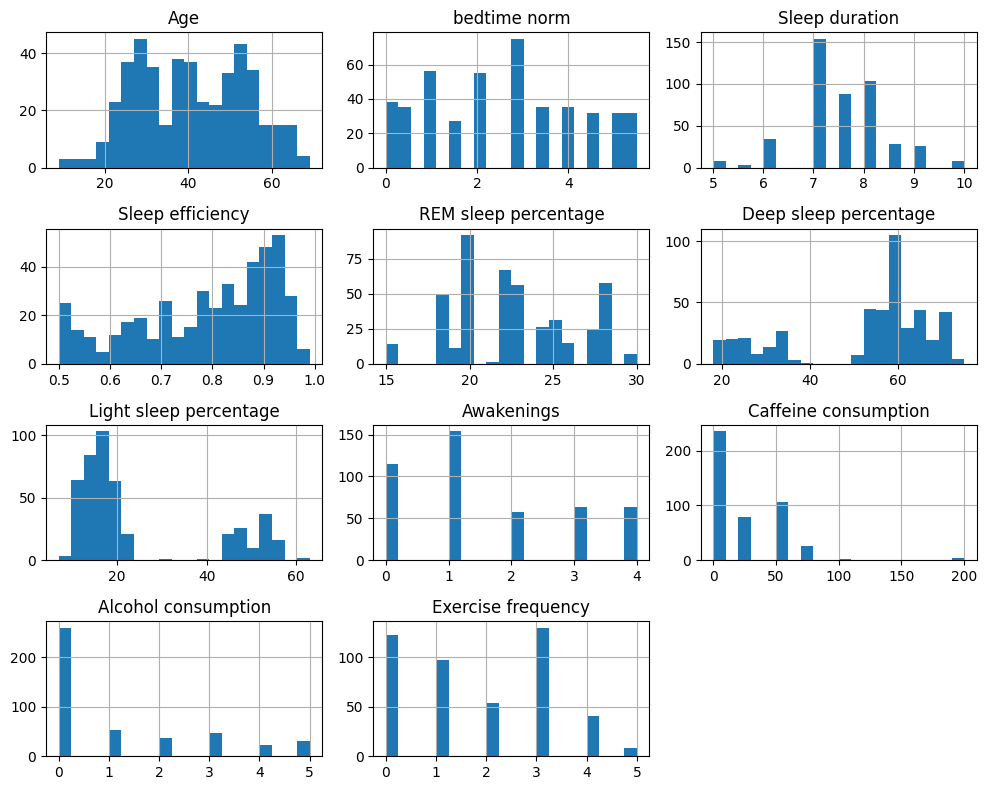

In [6]:
#Розподіли значень:
df.hist(bins=20, figsize=(10, 8))
plt.tight_layout()
plt.show()

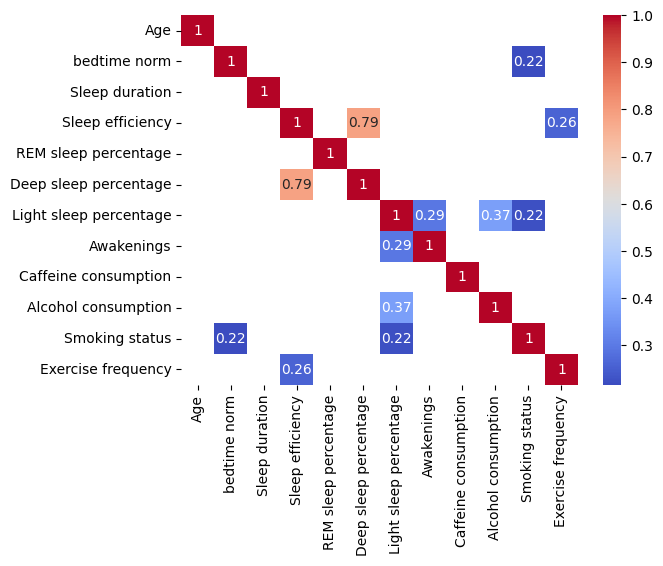

In [7]:
# Кореляція показників
correlation_matrix = df.corr()

# Маску для значень кореляції менше х
mask = correlation_matrix < 0.2
sns.heatmap(correlation_matrix, mask=mask, cmap='coolwarm', annot=True)
plt.show()

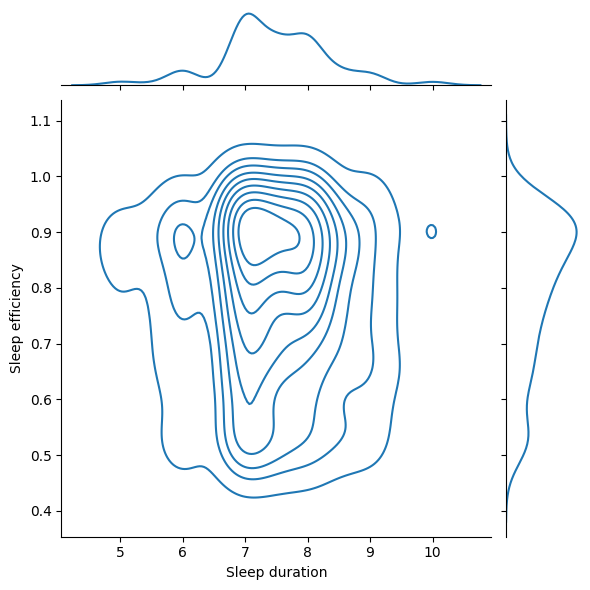

In [8]:
sns.jointplot(
    df,
    x='Sleep duration',
    y='Sleep efficiency',
    kind='kde'
)

# **Частина 2. Моделювання**
### ***(Створи як мінімум 2 різні регресійні моделі для прогнозування цільової змінної “Sleep efficiency”)***

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

# Розділення даних на навчальний та тестовий набори
X = df.drop(columns=['Sleep efficiency'])
y = df['Sleep efficiency']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### ***2.1. Модель 1 - Лінійна регресія***

In [10]:
# Лінійна регресія
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)
y_pred_linear = linear_reg.predict(X_test)

# Оцінка лінійної регресії за допомогою MSE та R^2
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)
print("Linear Regression - Mean Squared Error:", mse_linear)
print("Linear Regression - R^2 Score:", r2_linear)


Linear Regression - Mean Squared Error: 0.003909182268883989
Linear Regression - R^2 Score: 0.7900328431455159


### ***2.2. Модель 2 - Випадковий ліс***

In [11]:
# Випадковий ліс
random_forest = RandomForestRegressor(random_state=55)
random_forest = RandomForestRegressor(n_estimators=86)
random_forest.fit(X_train, y_train)
y_pred_rf = random_forest.predict(X_test)

# Оцінка випадкового лісу за допомогою MSE та R^2
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print("Random Forest - Mean Squared Error:", mse_rf)
print("Random Forest - R^2 Score:", r2_rf)


Random Forest - Mean Squared Error: 0.002484965143023561
Random Forest - R^2 Score: 0.8665293582966884


### ***2.3. Оцінка моделей за допомогою крос-валідації***

In [12]:
cv_scores_linear = cross_val_score(linear_reg, X, y, cv=5, scoring='neg_mean_squared_error')
cv_scores_rf = cross_val_score(random_forest, X, y, cv=5, scoring='neg_mean_squared_error')

print("Cross-Validation Linear Regression - Mean Squared Error:", -cv_scores_linear.mean())
print("Cross-Validation Random Forest - Mean Squared Error:", -cv_scores_rf.mean())

Cross-Validation Linear Regression - Mean Squared Error: 0.0038416501490737714
Cross-Validation Random Forest - Mean Squared Error: 0.002591441223223327


# **Частина 3. Аналіз результатів**
### ***Для всіх моделей побудуй графіки порівняння справжніх та спрогнозованих даних.***

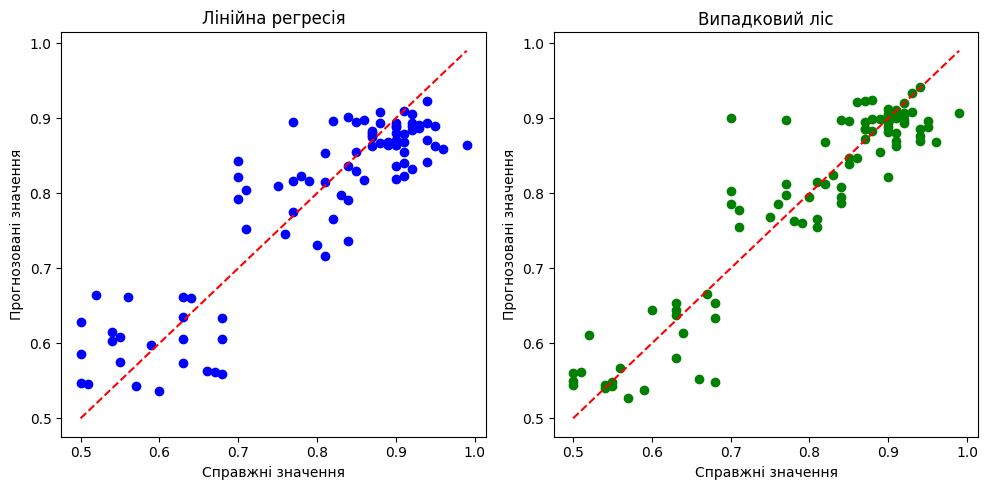

In [13]:
import matplotlib.pyplot as plt

# Графіки для лінійної регресії
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_linear, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')
plt.xlabel('Справжні значення')
plt.ylabel('Прогнозовані значення')
plt.title('Лінійна регресія')

# Графіки для випадкового лісу
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_rf, color='green')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red')
plt.xlabel('Справжні значення')
plt.ylabel('Прогнозовані значення')
plt.title('Випадковий ліс')

plt.tight_layout()
plt.show()


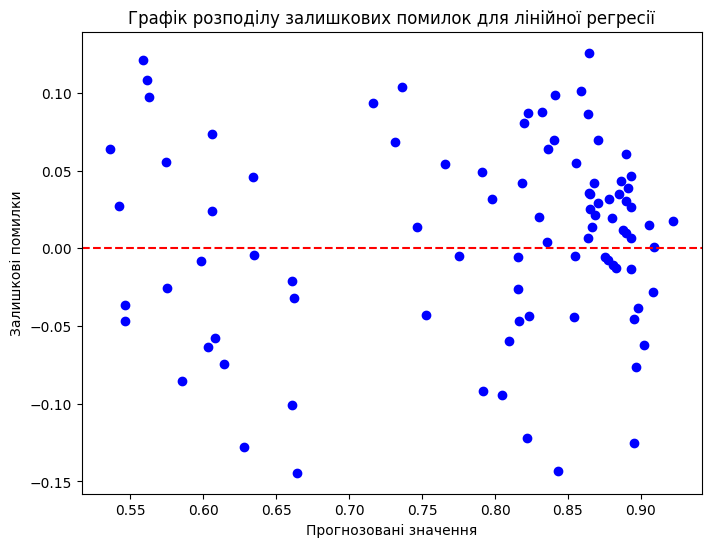

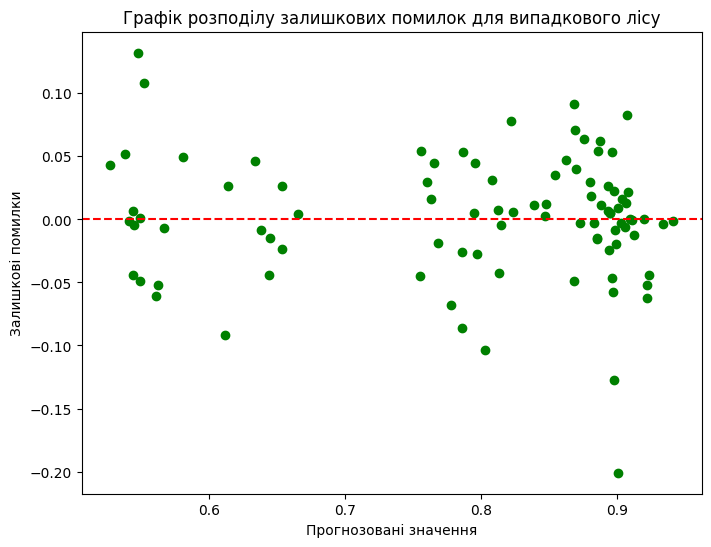

In [18]:
import matplotlib.pyplot as plt

# Обчислення залишків для лінійної регресії
residuals_linear = y_test - y_pred_linear

# Графік розподілу залишкових помилок для лінійної регресії
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_linear, residuals_linear, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Прогнозовані значення')
plt.ylabel('Залишкові помилки')
plt.title('Графік розподілу залишкових помилок для лінійної регресії')
plt.show()

# Обчислення залишків для випадкового лісу
residuals_rf = y_test - y_pred_rf

# Графік розподілу залишкових помилок для випадкового лісу
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_rf, residuals_rf, color='green')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Прогнозовані значення')
plt.ylabel('Залишкові помилки')
plt.title('Графік розподілу залишкових помилок для випадкового лісу')
plt.show()


In [15]:
# Різниця між справжніми та прогнозованими значеннями для лінійної регресії
linear_errors = y_test - y_pred_linear

# Вивести індекси рядків з найбільшими за модулем помилками для кожної моделі
linear_max_errors = linear_errors.abs().nlargest(5).index

print("Найбільші за модулем помилки для лінійної регресії:")
df.loc[linear_max_errors]


Найбільші за модулем помилки для лінійної регресії:


,Age,bedtime norm,Sleep duration,Sleep efficiency,REM sleep percentage,Deep sleep percentage,Light sleep percentage,Awakenings,Caffeine consumption,Alcohol consumption,Smoking status,Exercise frequency
287,40,0.5,7.5,0.52,23,25,52,0.0,75.0,2.0,True,3.0
77,46,5.0,9.0,0.70,18,70,12,1.0,0.0,5.0,True,3.0
117,30,0.5,8.0,0.50,20,35,45,1.0,0.0,5.0,True,0.0
56,54,4.0,8.0,0.99,27,55,18,1.0,0.0,3.0,False,3.0
209,61,5.0,9.0,0.77,20,70,10,1.0,0.0,0.0,True,3.0


In [16]:
# Різниця між справжніми та прогнозованими значеннями для випадкового лісу
rf_errors = y_test - y_pred_rf

# Вивести індекси рядків з найбільшими за модулем помилками для кожної моделі
rf_max_errors = rf_errors.abs().nlargest(5).index

print("\nНайбільші за модулем помилки для випадкового лісу:")
df.loc[rf_max_errors]



Найбільші за модулем помилки для випадкового лісу:


,Age,bedtime norm,Sleep duration,Sleep efficiency,REM sleep percentage,Deep sleep percentage,Light sleep percentage,Awakenings,Caffeine consumption,Alcohol consumption,Smoking status,Exercise frequency
77,46,5.0,9.0,0.70,18,70,12,1.0,0.0,5.0,True,3.0
75,44,3.5,8.5,0.68,26,28,46,2.0,0.0,0.0,True,1.0
209,61,5.0,9.0,0.77,20,70,10,1.0,0.0,0.0,True,3.0
417,44,1.0,7.0,0.66,20,35,45,4.0,0.0,3.0,True,3.0
153,41,5.5,7.5,0.70,22,59,19,3.0,0.0,0.0,False,3.0


## **Висновки:**



**1. Лінійна регресія:**

>> MSE: 0.00391

>> R^2 Score: 0.790

>> Модель лінійної регресії показала гарні результати з високим коефіцієнтом детермінації (R^2), що означає, що вона добре пояснює варіативність цільової змінної. Проте графік показує, що є деякі відхилення між справжніми та прогнозованими значеннями, ***особливо для високих значень "Sleep efficiency"***.



**2.   Випадковий ліс:**

>> MSE: 0.00254

>> R^2 Score: 0.863

>> Модель випадкового лісу показала ще кращі результати, з нижчим значенням MSE і вищим коефіцієнтом детермінації (R^2). Графік також показує менші відхилення між справжніми та прогнозованими значеннями, що свідчить про кращу точність моделі.


**Отже, на основі аналізу якості та графічного представлення прогнозів можна зробити висновок, що модель випадкового лісу є більш точною для цих даних, оскільки вона має меншу середньоквадратичну помилку і вищий коефіцієнт детермінації.**